Autor do Notebook: Otávio Azevedo de Carvalho Kamel Barbosa

# 0. Importação e Configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [2]:
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 30)
pd.set_option('min_rows', 10)
pd.options.display.float_format = '{:.2f}'.format

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

## 0.1 Carregando o Conjunto de Dados

In [3]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

raw_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30
1,396.90,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80
3,396.90,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80
...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,0.11,0.00,11.93,0.00,0.57,6.79,89.30,2.39,1.00,273.00,21.00
1009,393.45,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,0.05,0.00,11.93,0.00,0.57,6.03,80.80,2.50,1.00,273.00,21.00


In [4]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True)

In [5]:
data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [6]:
boston = load_boston()
X = boston.data
y = boston.target

C:\Users\Kamel\.conda\envs\tf-gpu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing 

In [7]:
df1 = pd.DataFrame(X, columns = ['CRIM','ZN','INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B 1000', 'LSTAT'])

In [8]:
df1['MEDV'] = y

# 0.2 Funções de Ajuda

In [9]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
     
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0])

# 1. Descrição dos Dados

## 1.1 Tipos e Dimensão dos Dados

In [10]:
df1.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B 1000   506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [12]:
print(f'O dataset possui {df1.shape[0]} linhas e {df1.shape[1]} colunas')

O dataset possui 506 linhas e 14 colunas


## 1.2 Dados Duplicados

In [13]:
df1[df1.duplicated()]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV


## 1.3 Dados Faltantes

In [14]:
df1.isna().sum().sum()

0

## 1.4 Análise Descritiva dos Dados

In [15]:
df1.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


In [16]:
# tendencia central, média e mediana
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T

# dispersão - desvio padrão, min, max, amplitude, skewness, kurtosis
d1 = pd.DataFrame(df1.apply(np.std)).T
d2 = pd.DataFrame(df1.apply(min)).T
d3 = pd.DataFrame(df1.apply(max)).T
d4 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']
m.index = m['attributes']
m.drop('attributes', axis=1, inplace=True)
m

,min,max,range,mean,median,std,skewness,kurtosis
attributes,,,,,,,,
CRIM,0.01,88.98,88.97,3.61,0.26,8.59,5.22,37.13
ZN,0.00,100.00,100.00,11.36,0.00,23.30,2.23,4.03
INDUS,0.46,27.74,27.28,11.14,9.69,6.85,0.30,-1.23
CHAS,0.00,1.00,1.00,0.07,0.00,0.25,3.41,9.64
NOX,0.39,0.87,0.49,0.55,0.54,0.12,0.73,-0.06
RM,3.56,8.78,5.22,6.28,6.21,0.70,0.40,1.89
AGE,2.90,100.00,97.10,68.57,77.50,28.12,-0.60,-0.97
DIS,1.13,12.13,11.00,3.80,3.21,2.10,1.01,0.49
RAD,1.00,24.00,23.00,9.55,5.00,8.70,1.00,-0.87


# 2.0 Análise Exploratória de Dados

## 2.1 Análise Univariada

### 2.1.1 Variável Resposta

C:\Users\Kamel\.conda\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


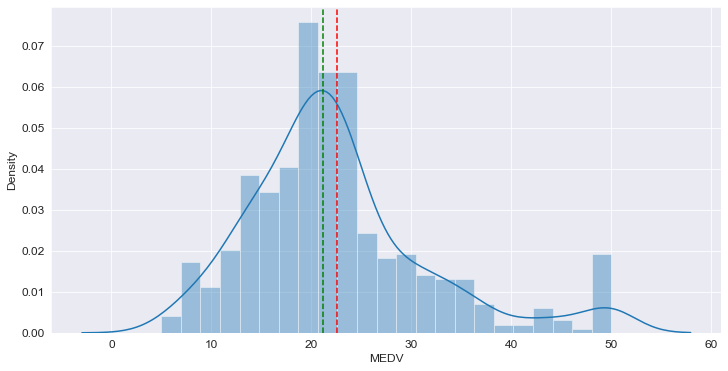

In [17]:
plt.figure(figsize=(12, 6))
sns.distplot(df1['MEDV'], kde=True)
plt.axvline(df1['MEDV'].mean(), label='Mean', linestyle='--', color='red')
plt.axvline(df1['MEDV'].median(), label='Median', linestyle='--', color='green')

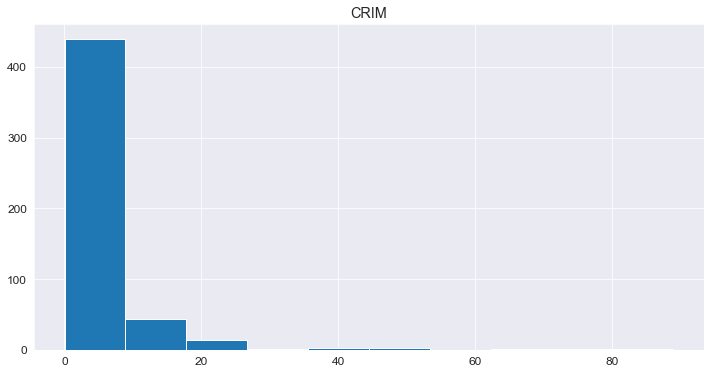

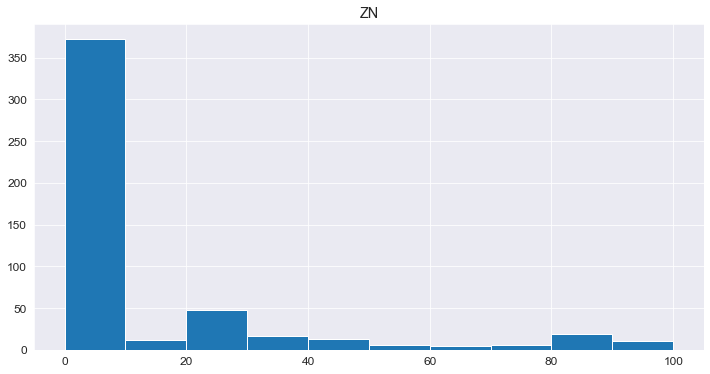

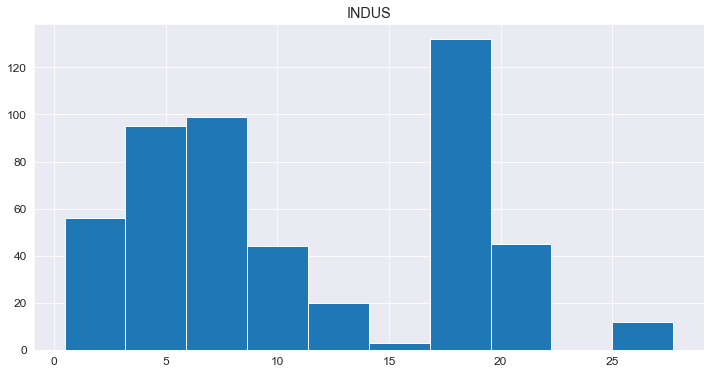

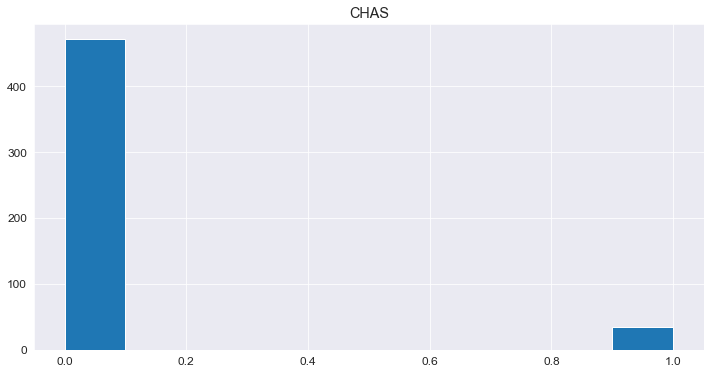

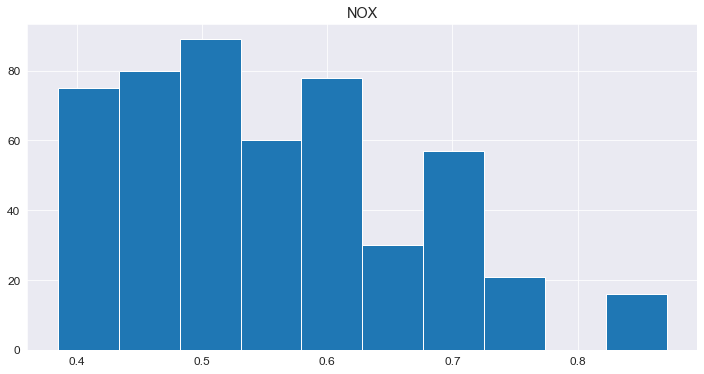

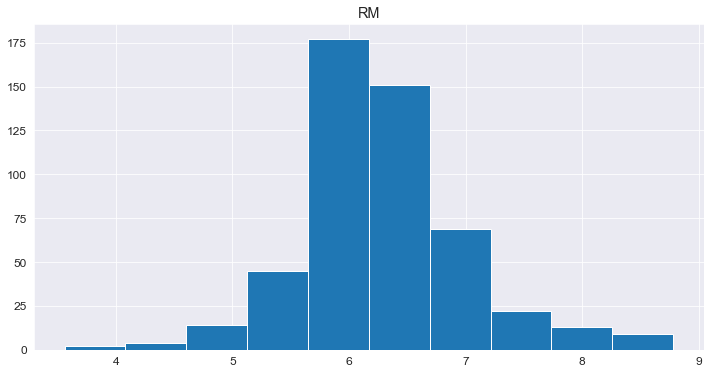

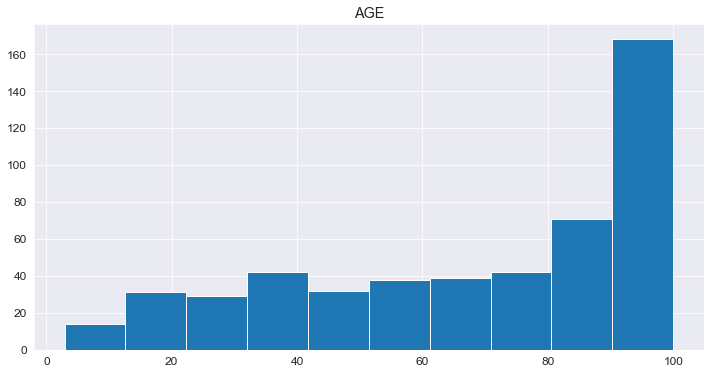

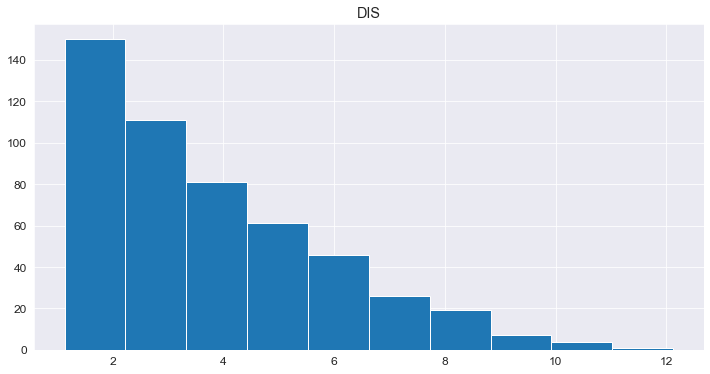

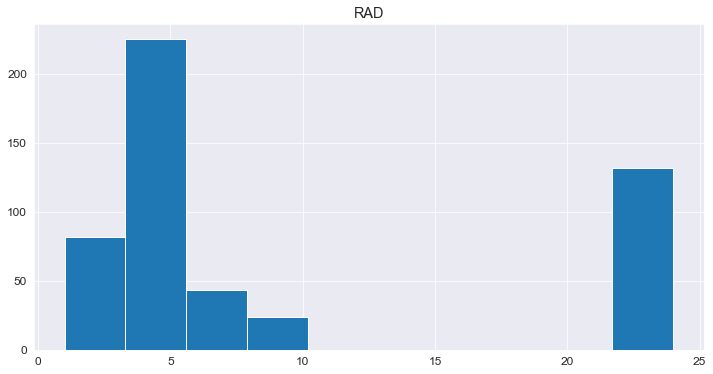

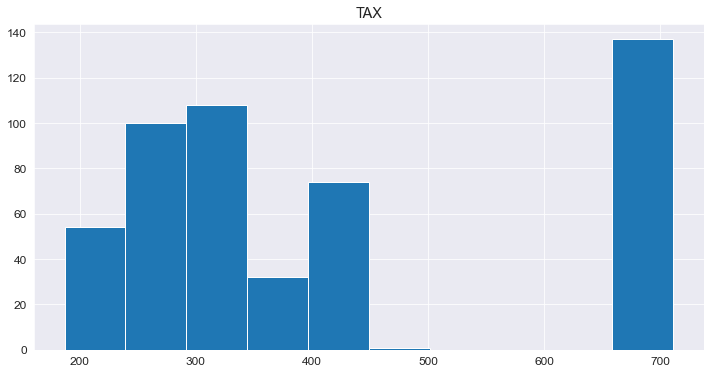

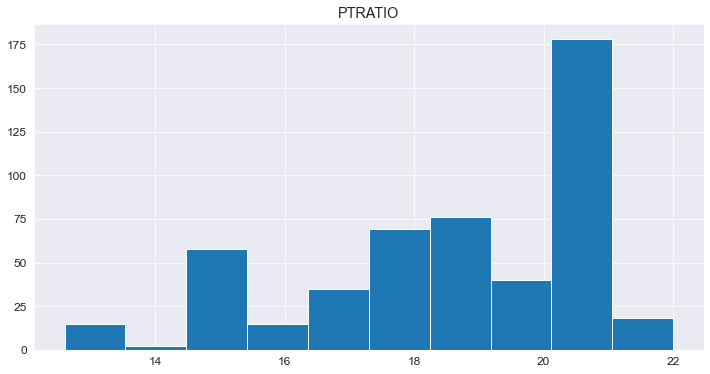

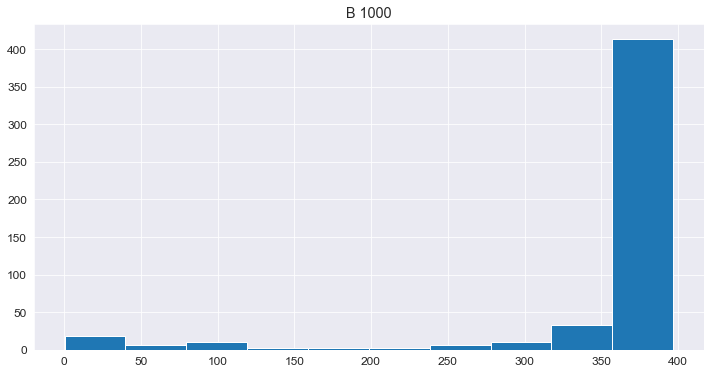

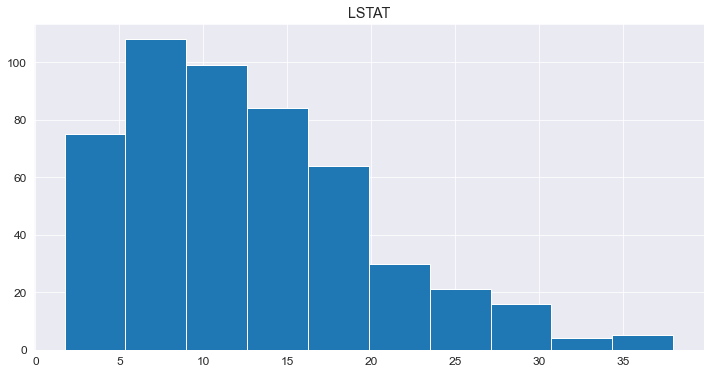

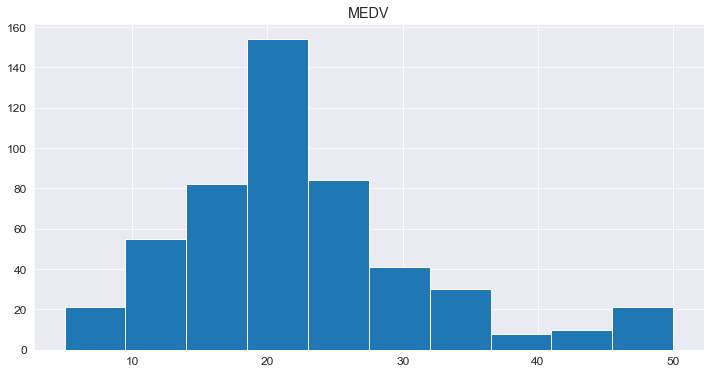

In [18]:
for col in df1.columns:
    plt.hist(df1[col])
    plt.title(col)
    plt.show()
    
# a maior parte do crime per capita está concentrado em 10 casos por cidade, com alguns casos entre 10 e 30, e pouquíssimos fora dessas faixas.
# a proporção de terrenos residenciais zoneados para lotes acima de 25000 se concentram em até 10%, mas variam bastante de proporção no restante das observações.
# a proporção de acres de negócios não varejistas por cidade varia bastante, mas tem poucos registros entre os valores de 15% a 17,5%, e acima de 22,5%.
# podemos observar que a grande maioria das casas não estão ligadas ao Rio Charles.
# a concentração de óxidos nítricos possui mais valores entre 0,4 e 0,65, partes por 10 milhões; e possui poucos registros acima de 0.75 partes por 10 milhões.
# podemos ver que boa parte das casas residencias foram construídas antes de 1940.
# temos uma maior concentração de casas próximas a 5 centros de emprego de Boston e menos casas afastadas desses centros.
# uma parte da população tem bom acesso às rodoviais radiais, mas a maior parte possui um acesso mais complicado.
# uma quantidade razoável de casas pagam uma taxa de imposto de propriedade de valor total por US$ 10.000 mais elevada que a maioria (aproxidamente o dobro)
# a relação aluno-professor por cidade é em torno de 20 para a maioria das regiões.
# podemos perceber que a grande maioria das casas ficam em regiões com uma concentração de negros maior que 400
# a maioria das casas ficam em áreas com uma porcentagem de pessoas de baixo status menor que 20%.
# o valor mediano das casas ocupadas parece seguir uma distribuiçãi normal, com valores mais frequentes em torno dos 20000 dólares.

## 2.2 Análise Bivariada

### 2.2.1 **Hipótese** 1 - Casas em área com menor taxa de crime são MAIS CARAS
- ***Verdade***, embora não aparenta ser uma correlação linear tão forte, mas as casas com regiões de taxa de crime baixíssimas são mais caras em sua maioria

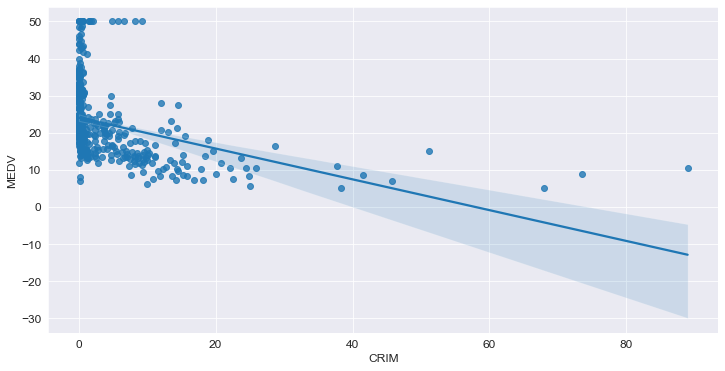

In [19]:
sns.regplot(data = df1, x='CRIM', y='MEDV');

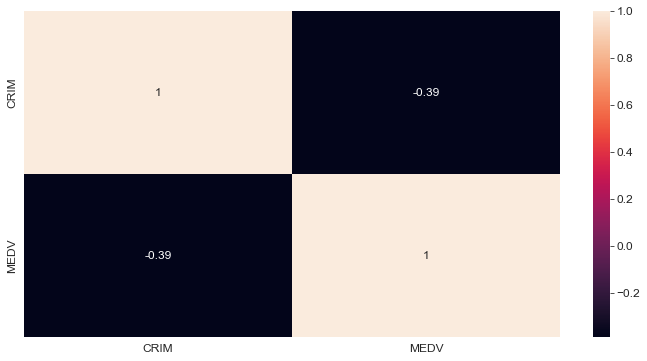

In [20]:
sns.heatmap(df1[['CRIM', 'MEDV']].corr(), annot=True);

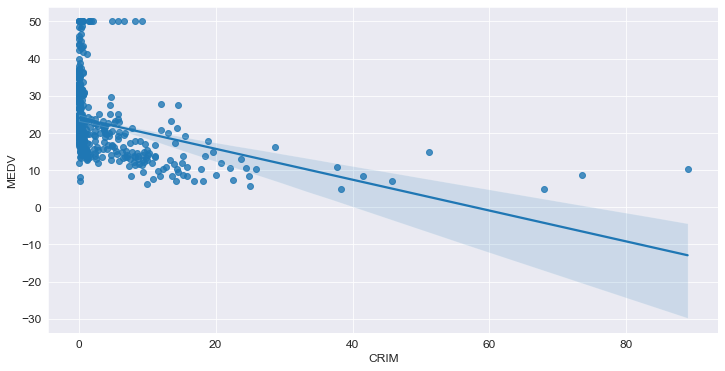

In [21]:
sns.regplot(data = df1, x='CRIM', y='MEDV');

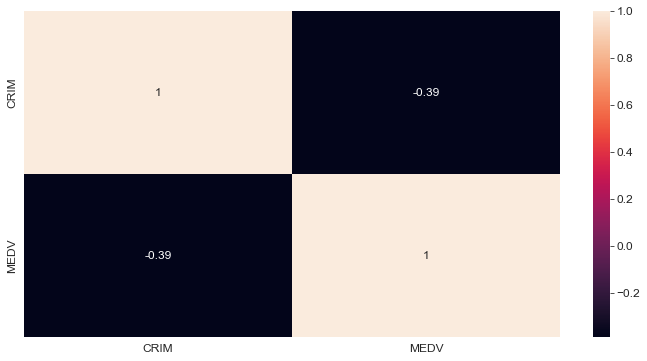

In [22]:
sns.heatmap(df1[['CRIM', 'MEDV']].corr(), annot=True);

### 2.2.2 **Hipóteses 2** Casas próximas ao Rio Charles são mais caras
- ***Verdadeiro***; as casas perto do Rio Charles possuem valores em média mais elevados.

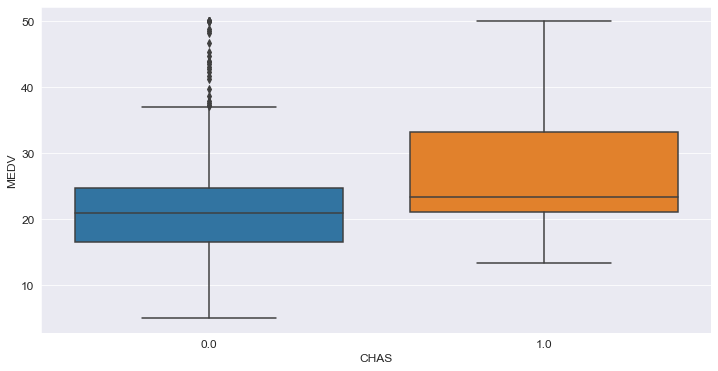

In [23]:
sns.boxplot(data=df1, x='CHAS', y='MEDV');

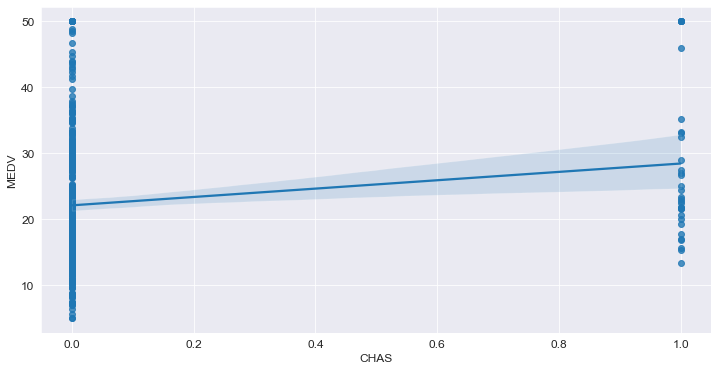

In [24]:
sns.regplot(data = df1, x='CHAS', y='MEDV');

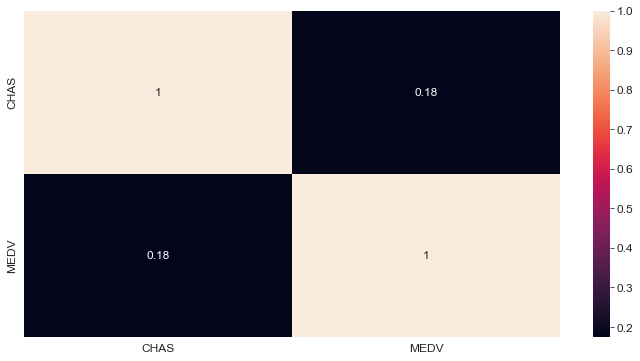

In [25]:
sns.heatmap(df1[['CHAS', 'MEDV']].corr(), annot=True);

### 2.2.3 **Hipótese** 3 - Casas em área com maior concentração de Óxido Nítrico são MAIS BARATAS
- ***Verdadeiro***, as casas em áreas com concentrações maiores de Óxido Nítrico possuem menor valor no geral

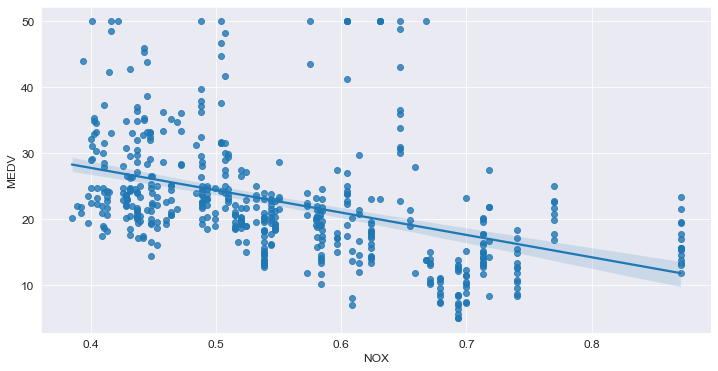

In [26]:
sns.regplot(data = df1, x='NOX', y='MEDV');

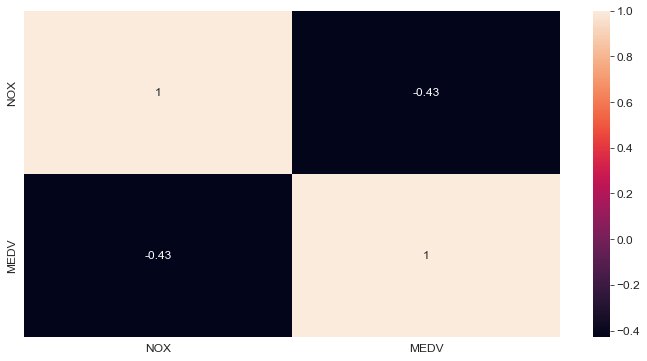

In [27]:
sns.heatmap(df1[['NOX', 'MEDV']].corr(), annot=True);

### 2.2.4 **Hipótese** 4 - Casas com maior número de quartos são MAIS CARAS
- ***Verdadeiro***, as casas que possuem mais quartos tendem a ter um maior valor de venda, e apresentam uma forte correlação linear positiva.

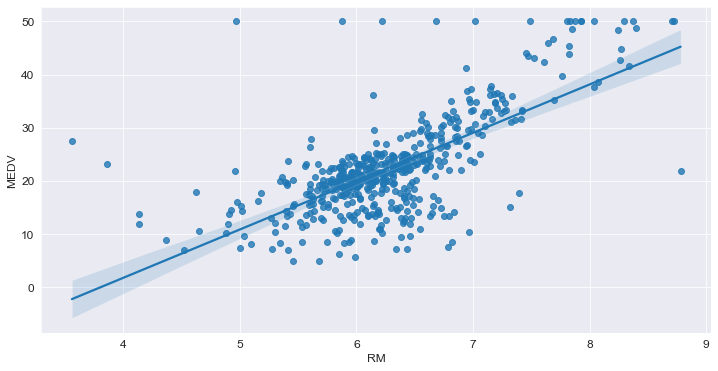

In [28]:
sns.regplot(data = df1, x='RM', y='MEDV');

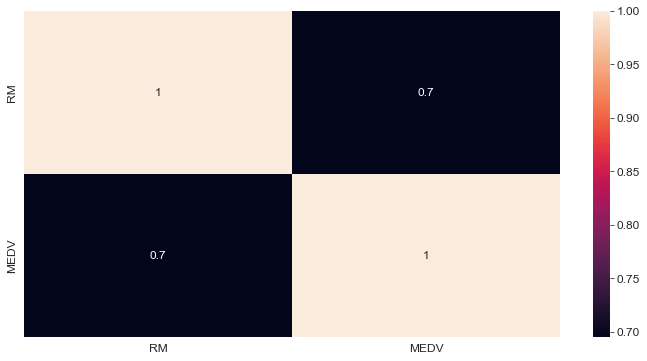

In [29]:
sns.heatmap(df1[['RM', 'MEDV']].corr(), annot=True);

### 2.2.5 **Hipótese** 5 - Casas mais antigas são MAIS BARATAS
- ***Verdadeiro***, embora não seja uma correlação linear muito evidente, as casas mais velhas possuem valores mais baixos.

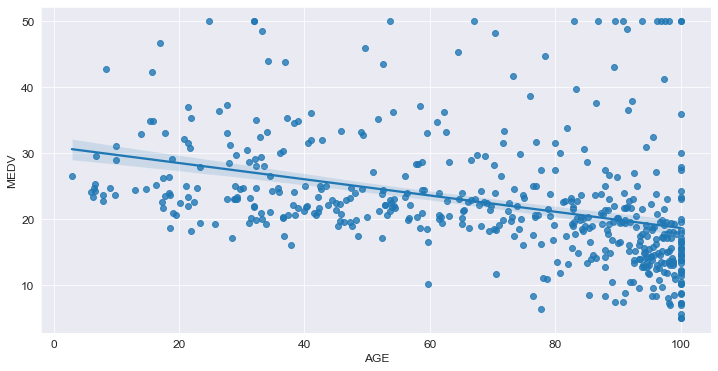

In [30]:
sns.regplot(data = df1, x='AGE', y='MEDV');

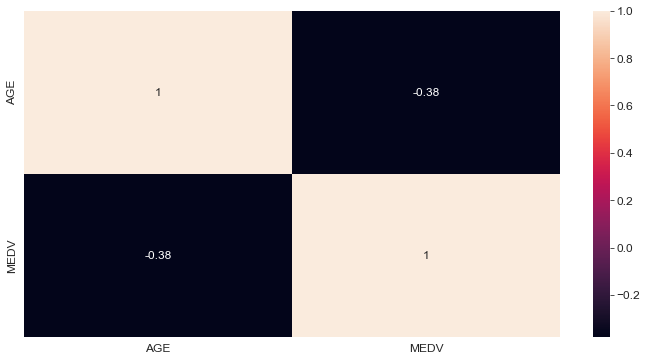

In [31]:
sns.heatmap(df1[['AGE', 'MEDV']].corr(), annot=True);

### 2.2.6 **Hipótese** 6 - Casas com maior valor de taxa de imposto de propriedade são MAIS CARAS
- ***Falso***. Ao contrário do esperado, as casas que possuem maior valor de imposto são mais baratas neste conjunto de dados.

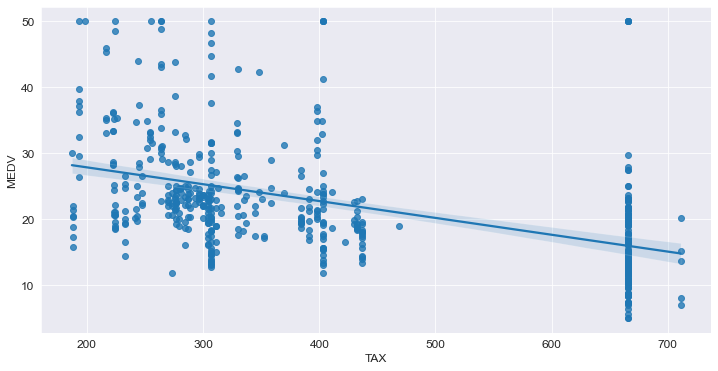

In [32]:
sns.regplot(data = df1, x='TAX', y='MEDV');

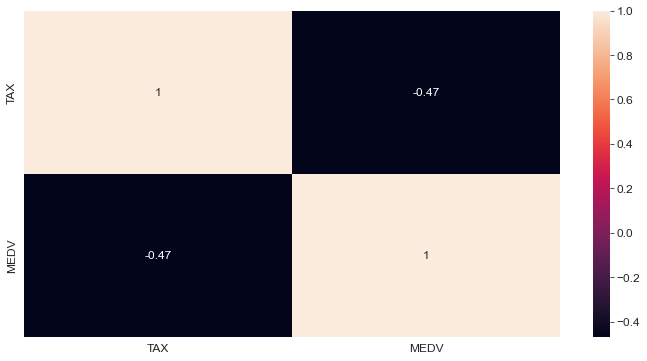

In [33]:
sns.heatmap(df1[['TAX', 'MEDV']].corr(), annot=True);

### 2.2.7 **Hipótese** 7 - Casas em área com menos alunos por professor são mais CARAS
- ***Verdadeiro***, como esperado, regiões em que há menos alunos por professor possuem casas mais caras.

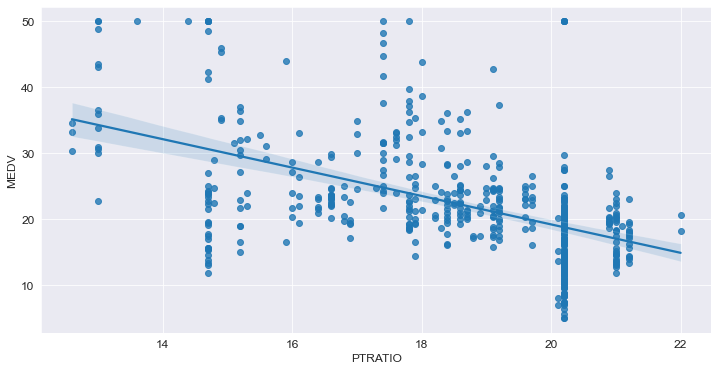

In [34]:
sns.regplot(data = df1, x='PTRATIO', y='MEDV');

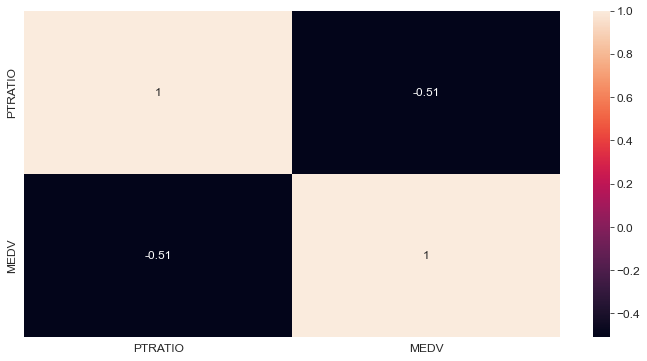

In [35]:
sns.heatmap(df1[['PTRATIO', 'MEDV']].corr(), annot=True);

### 2.2.8 **Hipótese** 8 - Locais com maior quantidade de Negros possuem casas MAIS BARATAS (fica uma observação aqui que isso é apenas uma hipótese baseada no conhecimento de que os Estados Unidos tem um histórico racista, e os dados reproduzem o viés preconceituoso do ser humano. Em nenhum momento quero menosprezar ou achar que os negros são inferiores às outras pessoas, muito pelo contrário.)
- ***Falso***. Ao contrário do esperado, as casas em regiões com maior concentração de Negros são mais caras.

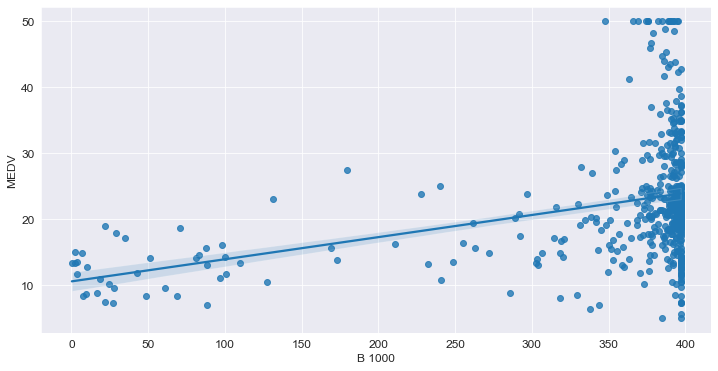

In [36]:
sns.regplot(data = df1, x='B 1000', y='MEDV');

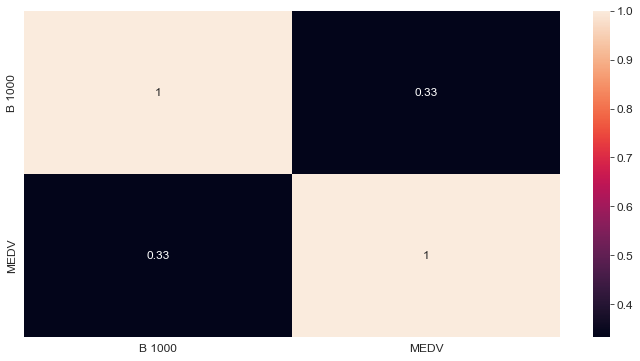

In [37]:
sns.heatmap(df1[['B 1000', 'MEDV']].corr(), annot=True);

### 2.2.9 **Hipótese** 9 - Áreas com menores percentuais de pessoas de baixo status social possuem casas MAIS CARAS.
- ***Verdadeiro***. A relação entre o percentual de pessoas de baixo status social e preço das casas possui uma forte correlação negativa.

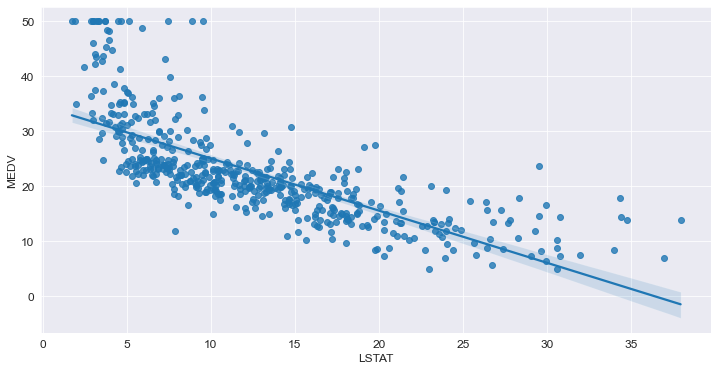

In [38]:
sns.regplot(data = df1, x='LSTAT', y='MEDV');

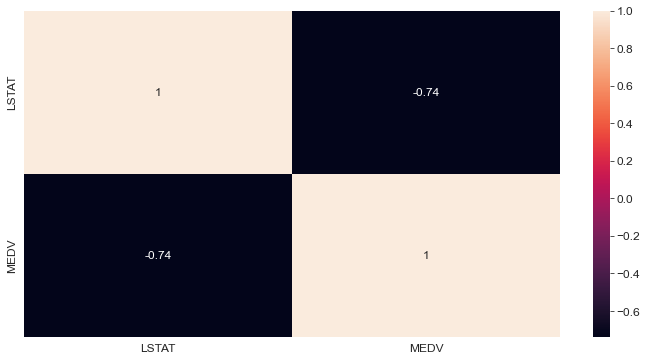

In [39]:
sns.heatmap(df1[['LSTAT', 'MEDV']].corr(), annot=True);

### 2.2.10 Análise Multivariada

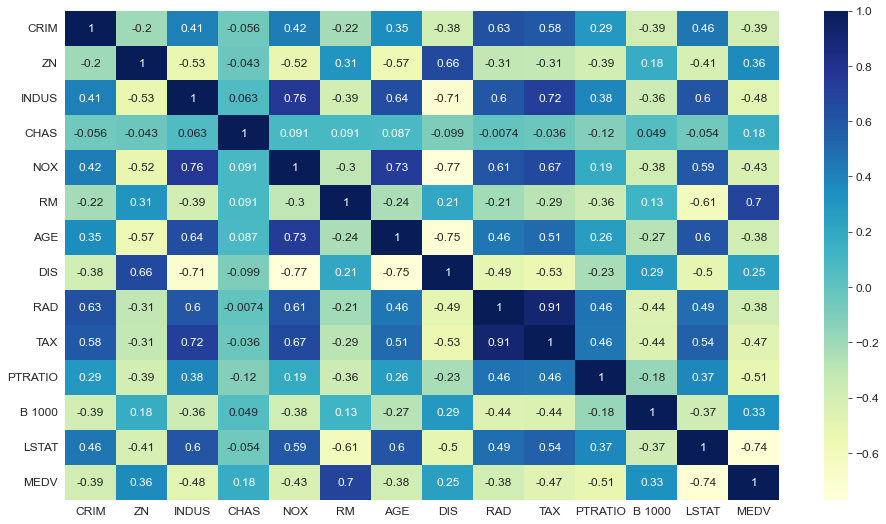

In [40]:
correlation = df1.corr(method='pearson')
plt.figure(figsize=(16, 9))
sns.heatmap(correlation, annot=True, cmap='YlGnBu');

# 3.0 Engenharia de Recursos

In [41]:
df3 = df1.copy()

In [42]:
df3.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


## 3.1 Escalonamento

In [43]:
mms = MinMaxScaler()

for col in df3.drop('MEDV', axis=1).columns:
    df3[col] = mms.fit_transform(df3[[col]])

In [44]:
df3.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV
0,0.00,0.18,0.07,0.00,0.31,0.58,0.64,0.27,0.00,0.21,0.29,1.00,0.09,24.00
1,0.00,0.00,0.24,0.00,0.17,0.55,0.78,0.35,0.04,0.10,0.55,1.00,0.20,21.60
2,0.00,0.00,0.24,0.00,0.17,0.69,0.60,0.35,0.04,0.10,0.55,0.99,0.06,34.70
3,0.00,0.00,0.06,0.00,0.15,0.66,0.44,0.45,0.09,0.07,0.65,0.99,0.03,33.40
4,0.00,0.00,0.06,0.00,0.15,0.69,0.53,0.45,0.09,0.07,0.65,1.00,0.10,36.20


In [45]:
df3.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,0.04,0.11,0.39,0.07,0.35,0.52,0.68,0.24,0.37,0.42,0.62,0.90,0.30,22.53
std,0.10,0.23,0.25,0.25,0.24,0.13,0.29,0.19,0.38,0.32,0.23,0.23,0.20,9.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00
25%,0.00,0.00,0.17,0.00,0.13,0.45,0.43,0.09,0.13,0.18,0.51,0.95,0.14,17.02
50%,0.00,0.00,0.34,0.00,0.31,0.51,0.77,0.19,0.17,0.27,0.69,0.99,0.27,21.20
75%,0.04,0.12,0.65,0.00,0.49,0.59,0.94,0.37,1.00,0.91,0.81,1.00,0.42,25.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,50.00


## 3.2 Divisão do conjunto de dados em Treino, Validação e Teste

In [46]:
X_train, X_test, y_train, y_test =  train_test_split(df3.drop(['MEDV'], axis=1), df3['MEDV'], random_state = 16, train_size=0.8)

print('Tamanho teste: {}'.format(X_test.shape[0]))

Tamanho teste: 102


In [47]:
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, random_state = 16, train_size=0.8)

print('\nTamanho treino: {}'.format(X_train.shape[0]))
print('Tamanho validação: {}'.format(X_val.shape[0]))


Tamanho treino: 323
Tamanho validação: 81


## 3.3 Seleção de Atributos Boruta

In [48]:
# training and test dataset for Boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

In [49]:
# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-2)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	4
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	4
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	4
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	4
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	4
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	4
Iteration:

### 3.3.1 Melhores Atributos Boruta

In [50]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [51]:
cols_selected_boruta

['CRIM', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'LSTAT']

In [52]:
cols_not_selected_boruta

['B 1000', 'CHAS', 'INDUS', 'RAD', 'ZN']

## 3.4 Seleção por Importância

### 3.4.1 Seleção de Atributos com Random Forest

In [53]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42 ).fit(X_train_n, y_train_n)

In [54]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
RM,0.45
LSTAT,0.35
DIS,0.07
CRIM,0.03
AGE,0.02
TAX,0.02
PTRATIO,0.02
NOX,0.01
B 1000,0.01
INDUS,0.01


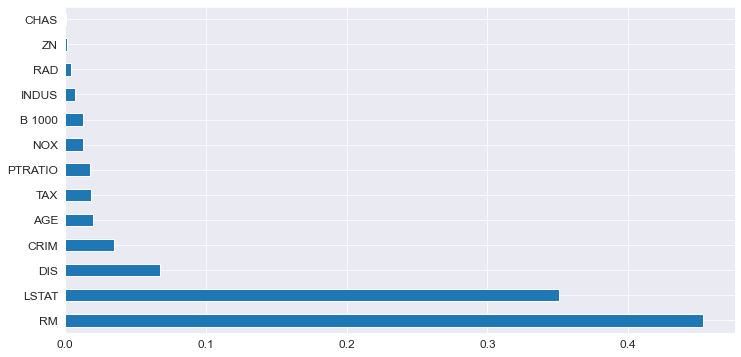

In [55]:
pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(len(X_train.columns)).plot(kind='barh');

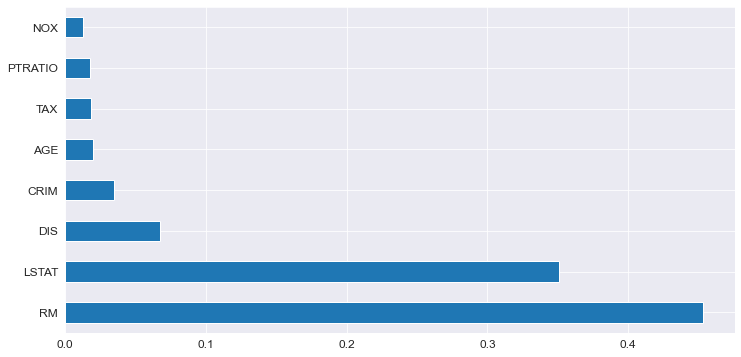

In [56]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh');

### 3.4.2 Seleção de Atributos com Extra Trees

In [57]:
et = ExtraTreesRegressor(n_jobs=-5)
et.fit(X_train_n, y_train_n)

feature_importances = pd.DataFrame(et.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
RM,0.35
LSTAT,0.34
PTRATIO,0.05
NOX,0.04
CRIM,0.03
TAX,0.03
DIS,0.03
INDUS,0.03
B 1000,0.02
AGE,0.02


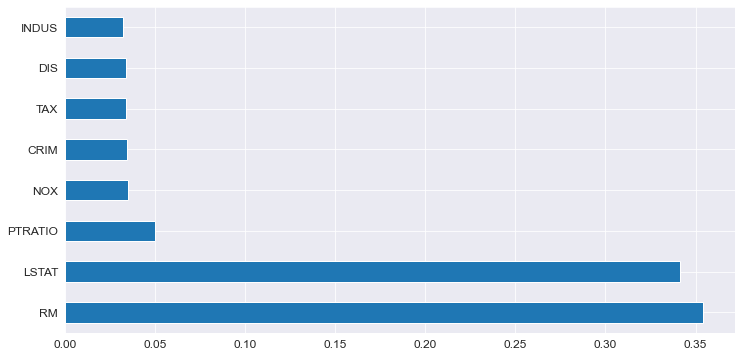

In [58]:
feat_importances = pd.Series(et.feature_importances_, X_train.columns)
feat_importances.nlargest(8).plot(kind='barh');

## 3.5 Seleção de Features Manual

In [59]:
# Baseado nos resultados do Boruta, Random Forest, Extra Trees e Análise Exploratória, seleciono as seguintes variáveis para o modelo de regressão:
cols_selected = [
 'RM',
 'LSTAT',   # retirei CRIM pois acho que esteja relacionado com a variável LSTAT
 'PTRATIO',
 'TAX', 
 'DIS', 
 'AGE',
 'NOX']

target = df3['MEDV']

# 4.0 Machine Learning

In [60]:
x_train = X_train[cols_selected]
x_val = X_val[cols_selected]
x_test = X_test[cols_selected]

## 4.1 Dummy Average Model (para servir de baseline)

In [61]:
aux1 = x_val.copy()
aux1['MEDV'] = y_val.copy()

# prediction
yhat_baseline = np.repeat(np.mean(y_train), repeats=y_val.shape)

# performance
baseline_result = ml_error('Average Model', y_val, yhat_baseline)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,7.83,0.56,9.99


## 4.2 Linear Regression Model

In [62]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_val)

# performance
lr_result = ml_error('Linear Regression', (y_val), (yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,3.46,0.20,5.55


## 4.3 Linear Regression Regularized Model - Lasso

In [63]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_val )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', ( y_val ), ( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,3.45,0.20,5.55


In [64]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

NameError: name 'cross_validation' is not defined

ESTES RESULTADOS DOS MODELOS LINEARES SEREM PIORES DO QUE O AVERAGE MODEL INDICAM QUE O FENÔMENO ESTUDADO NÃO POSSUI MUITAS CARACTERÍSTICAS LINEARES, ELE É UM FENÔMENO MAIS COMPLEXO, QUE VAI PRECISAR DE OUTROS TIPOS DE MODELOS NÃO LINEARES, MAIS COMPLEXOS

## 4.4 Random Forest Model

In [65]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_val)

# performance
rf_result = ml_error('Random Forest Regressor', ( y_val ), ( yhat_rf ))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2.23,0.14,2.84


## 4.5 Comparação de Performances dos Modelos no Conjunto de Validação

In [66]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2.23,0.14,2.84
0,Linear Regression,3.46,0.20,5.55
0,Linear Regression - Lasso,3.45,0.20,5.55
0,Average Model,7.83,0.56,9.99


# 5.0 Resultados no conjunto de Teste

## 5.1 Dummy Average Model (para servir de baseline)

In [67]:
aux1 = x_test.copy()
aux1['MEDV'] = y_test.copy()

# prediction
yhat_baseline = np.repeat(np.mean(y_train), repeats=y_test.shape)

# performance
baseline_result = ml_error('Average Model', y_test, yhat_baseline)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,7.08,0.47,8.81


## 5.2 Linear Regression

In [68]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', (y_test), (yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,3.79,0.24,4.97


## 5.3 Linear Regression Regularized Model - Lasso

In [69]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', ( y_test ), ( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,3.79,0.24,4.97


## 5.4 Random Forest Model

In [70]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', ( y_test ), ( yhat_rf ))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2.20,0.13,3.03


## 5.5 Performance dos Modelos de Teste

In [71]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,2.20,0.13,3.03
0,Linear Regression - Lasso,3.79,0.24,4.97
0,Linear Regression,3.79,0.24,4.97
0,Average Model,7.08,0.47,8.81


# Diferencial

In [72]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [73]:
X = df1[['CRIM','ZN','INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B 1000', 'LSTAT']]
X = sm.add_constant(X)

olsmod = sm.OLS(df1['MEDV'], X).fit()
print(olsmod.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 19 Mar 2022   Prob (F-statistic):          6.72e-135
Time:                        11:51:07   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

C:\Users\Kamel\.conda\envs\tf-gpu\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [74]:
print('R2 score:', olsmod.rsquared)

R2 score: 0.7406426641094095


In [75]:
print('F-statistic:', olsmod.fvalue)
print('Probability of observing value at least as high as F-statistic:', olsmod.f_pvalue)

F-statistic: 108.07666617432623
Probability of observing value at least as high as F-statistic: 6.722174750114365e-135


In [76]:
print(olsmod.pvalues)

const     0.00
CRIM      0.00
ZN        0.00
INDUS     0.74
CHAS      0.00
NOX       0.00
RM        0.00
AGE       0.96
DIS       0.00
RAD       0.00
TAX       0.00
PTRATIO   0.00
B 1000    0.00
LSTAT     0.00
dtype: float64


In [77]:
df1['pie_sales_pred'] = olsmod.predict(X)
df1['residual'] = olsmod.resid
df1.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B 1000,LSTAT,MEDV,pie_sales_pred,residual
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00,30.00,-6.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60,25.03,-3.43
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70,30.57,4.13
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40,28.61,4.79
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20,27.94,8.26


p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 2.16218346317203e-25


C:\Users\Kamel\.conda\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


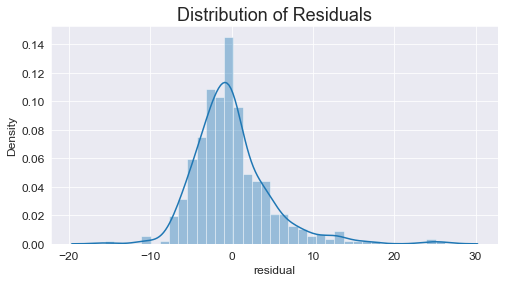

Residuals are not normally distributed


In [78]:
from statsmodels.stats.diagnostic import normal_ad

# Performing the test on the residuals
p_value = normal_ad(df1['residual'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

# Plotting the residuals distribution
plt.subplots(figsize=(8, 4))
plt.title('Distribution of Residuals', fontsize=18)
sns.distplot(df1['residual'])
plt.show()

# Reporting the normality of the residuals
if p_value < 0.05:
    print('Residuals are not normally distributed')
else:
    print('Residuals are normally distributed')

In [79]:
from statsmodels.stats.stattools import durbin_watson

durbinWatson = durbin_watson(df1['residual'])

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 1.0783751186797248
Signs of positive autocorrelation 

Assumption not satisfied


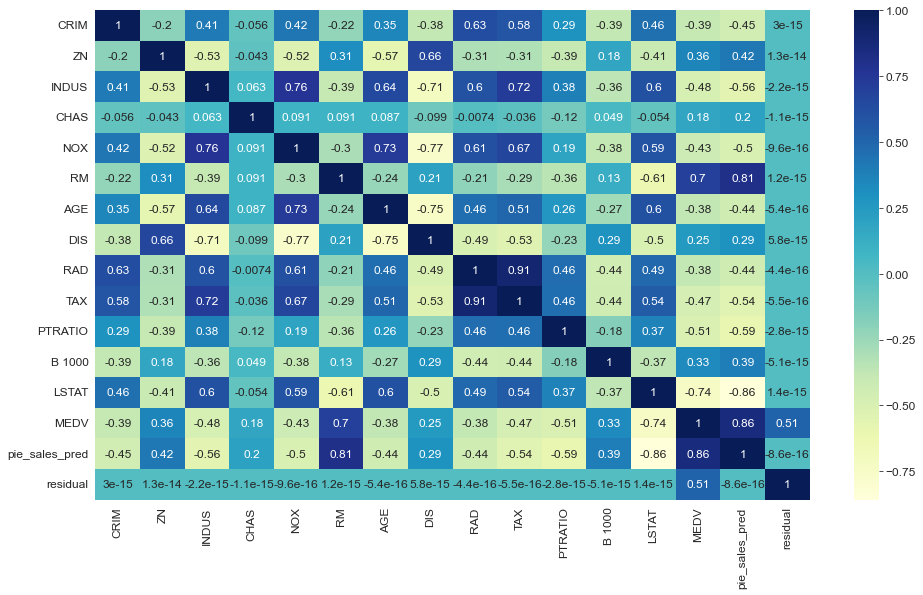

In [80]:
correlation = df1.corr(method='pearson')
plt.figure(figsize=(16, 9))
sns.heatmap(correlation, annot=True, cmap='YlGnBu');

- É possível afirmar que um modelo de regressão linear no conjunto de dados de Boston viola o número de suposições que causam problemas significativos com a interpretação do próprio modelo? Explique.

Este conjunto de dados de Boston se usado em sua totalidade viola as suposições de um modelo de regressão.

- Em primeiro lugar, há variáveis que não parecem ser independentes entre si, por exemplo: a porcentagem de pessoas de baixo status social e criminalidade pode influenciar uma a outra
- Os erros do modelo não são normalmente distribuídos
- O teste de Durbin-Watson determinou que o conjunto de dados falhou para a suposição de autocorrelação entre as variáveis.